<a href="https://colab.research.google.com/github/aquibjaved/Bits_and_Pieces_DL/blob/main/Basics_of_lora_implementation_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.nn.utils.parametrize as P
from sklearn.datasets import load_iris
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import math

In [26]:
# Define a transform to normalize the data and flatten each image into a 1D array
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data)
    target = torch.tensor(target)
    return data.cuda(), target.cuda()

In [27]:
def plot_flattened_images(flattened_images, labels, img_shape, class_names, num_images=5):
    """
    Plots images that have been flattened.

    Parameters:
        flattened_images (torch.Tensor): The flattened images tensor.
        labels (torch.Tensor): The labels tensor.
        img_shape (tuple): The original shape of the images (e.g., (28, 28) for Fashion MNIST).
        class_names (list): List of class names.
        num_images (int): Number of images to plot.
    """
    # Reshape the flattened images back to their original shape
    reshaped_images = flattened_images.view(-1, *img_shape).numpy()

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

    for i, ax in enumerate(axes):
        img = reshaped_images[i]
        label = class_names[labels[i].item()]
        ax.imshow(img, cmap='gray')
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [28]:
train_dataset = datasets.FashionMNIST('~/.data', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('~/.data', download=True, train=False, transform=transform)

In [29]:
def split_dataset(dataset, labels):
    indices = [i for i, (data, label) in enumerate(dataset) if label in labels]
    return torch.utils.data.Subset(dataset, indices)

labels_1 = [0, 1, 2, 3, 4]
labels_2 = [5, 6, 7, 8, 9]

train_dataset_04 = split_dataset(train_dataset, labels_1)
train_dataset_59 = split_dataset(train_dataset, labels_2)

batch_size = 64

train_loader_1 = torch.utils.data.DataLoader(train_dataset_04, batch_size=batch_size, shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(train_dataset_59, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

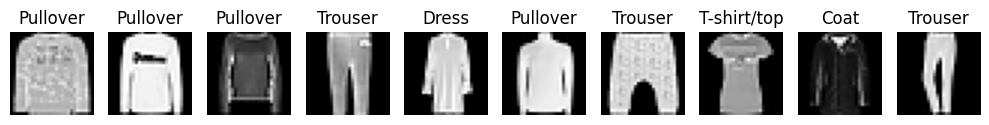

In [30]:
# Get one batch of images and labels
dataiter = iter(train_loader_1)
images, labels = next(dataiter)

# Define the class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_flattened_images(flattened_images=images, labels=labels, img_shape=(28,28), num_images=10, class_names=class_names)

In [31]:

class FashionNet(nn.Module):
  def __init__(self, input_dims, num_class):

    super().__init__()
    self.input_dims = input_dims
    self.num_class = num_class

    self.input_layer = nn.Linear(in_features=self.input_dims, out_features=1000)
    self.hidden_layer = nn.Linear(in_features=1000, out_features=2000)
    self.output_layer = nn.Linear(in_features=2000, out_features=self.num_class)

  def forward(self, x):
    out = F.relu(self.input_layer(x))
    out = F.relu(self.hidden_layer(out))
    out = self.output_layer(out)
    return out

In [32]:
# Check for GPU availability
cuda_available = torch.cuda.is_available()

In [33]:
import torch

def train_model(epochs:int, train_loader, model, optimizer, criterion):
  model.train()
  train_loss_per_epoch = []

  for epoch in range(epochs):

    running_loss_train = 0.0

    for data_batch, target_batch in train_loader:

        data_batch = data_batch.to('cuda')
        target_batch = target_batch.to('cuda')

        optimizer.zero_grad()
        output = model(data_batch)
        loss_train = criterion(output, target_batch)
        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.item()

    epcoh_loss_train = running_loss_train / len(train_loader)

    train_loss_per_epoch.append(epcoh_loss_train)


    if epoch %2 == 0:
      print(f'Epoch {epoch} Train loss {epcoh_loss_train}')
  return train_loss_per_epoch

device='cuda'

import torch
from sklearn.metrics import confusion_matrix
import numpy as np

def test(test_loader, net):
    correct = 0
    total = 0

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in test_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = net(x)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total +=1
    print(f'Accuracy: {round(correct/total, 3)}')
    for i in range(len(wrong_counts)):
        print(f'wrong counts for the Label {i}: {wrong_counts[i]}')



In [34]:
BigNet = FashionNet(input_dims=784, num_class=len(class_names))
optimizer = optim.SGD(BigNet.parameters(), lr=0.011, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Assume `model` is your model
if cuda_available:
    BigNet = BigNet.to('cuda')
    optimizer = optim.SGD(BigNet.parameters(), lr=0.011, momentum=0.9)
    criterion = nn.CrossEntropyLoss().to('cuda')

is_on_gpu = next(BigNet.parameters()).is_cuda
print(f'Model is on GPU: {is_on_gpu}')

trainable_params = sum(p.numel() for p in BigNet.parameters() if p.requires_grad)
print(f'Number of trainable (tunable) parameters: {trainable_params}')

Model is on GPU: True
Number of trainable (tunable) parameters: 2807010


In [35]:
trainLoss = train_model(epochs=10,
                        train_loader=train_loader_1,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=BigNet,
                        )

Epoch 0 Train loss 0.41786404888131723
Epoch 2 Train loss 0.2648093191736034
Epoch 4 Train loss 0.2280052561940415
Epoch 6 Train loss 0.20108639263808092
Epoch 8 Train loss 0.17698536431198436


In [36]:
torch.save(BigNet.state_dict(), 'model.pt')

In [37]:
# Call the function
test(
      test_loader=test_loader,
      net=BigNet,
)

original_weights = {}
for name, param in BigNet.named_parameters():
    original_weights[name] = param.clone().detach()

Accuracy: 0.455
wrong counts for the Label 0: 65
wrong counts for the Label 1: 28
wrong counts for the Label 2: 160
wrong counts for the Label 3: 73
wrong counts for the Label 4: 125
wrong counts for the Label 5: 1000
wrong counts for the Label 6: 1000
wrong counts for the Label 7: 1000
wrong counts for the Label 8: 1000
wrong counts for the Label 9: 1000


In [38]:
# Load the model and test it
model = FashionNet(input_dims=784, num_class=len(class_names))
model.load_state_dict(torch.load('model.pt'))
model.to('cuda')
# Call the function
test(
      test_loader=test_loader,
      net=model,
)

Accuracy: 0.455
wrong counts for the Label 0: 65
wrong counts for the Label 1: 28
wrong counts for the Label 2: 160
wrong counts for the Label 3: 73
wrong counts for the Label 4: 125
wrong counts for the Label 5: 1000
wrong counts for the Label 6: 1000
wrong counts for the Label 7: 1000
wrong counts for the Label 8: 1000
wrong counts for the Label 9: 1000


In [39]:
total_parameters_original = 0
for index, layer in enumerate([BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10])
Total number of parameters: 2,807,010


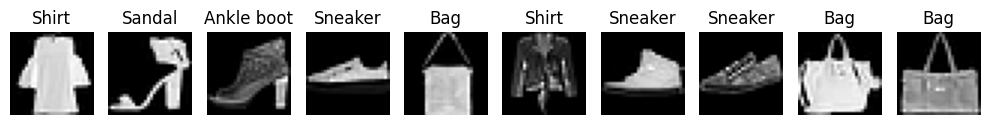

In [40]:
# Get one batch of images and labels
dataiter = iter(train_loader_2)
images, labels = next(dataiter)

# Define the class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_flattened_images(flattened_images=images, labels=labels, img_shape=(28,28), num_images=10, class_names=class_names)

In [65]:
class LoRaModel(nn.Module):
  def __init__(self, r: int, alpha_lora: int, input_dims: int, input_hidden_size: 1000, hidden_layer_size:2000, num_class:int):
    super().__init__()
    self.r = r
    self.alpha_lora = alpha_lora
    self.input_dims = input_dims
    self.input_hidden_size = input_hidden_size
    self.hidden_layer_size = hidden_layer_size
    self.num_class = num_class

    self.input_layer = nn.Linear(in_features=self.input_dims, out_features=self.input_hidden_size)
    self.hidden_layer = nn.Linear(in_features=self.input_hidden_size, out_features=self.hidden_layer_size)
    self.output_layer = nn.Linear(in_features=self.hidden_layer_size, out_features=self.num_class)


    self.input_lora_A = nn.Parameter(torch.empty(self.input_dims, self.r))


    self.input_lora_B = nn.Parameter(torch.empty(self.r, self.input_hidden_size))

    self.hidden_lora_A = nn.Parameter(torch.empty(self.input_hidden_size, self.r))
    self.hidden_lora_B = nn.Parameter(torch.empty(self.r, self.hidden_layer_size))

    self.output_lora_A = nn.Parameter(torch.empty(self.hidden_layer_size, self.r))
    self.output_lora_B = nn.Parameter(torch.empty(self.r, self.num_class))


    for n,p in self.named_parameters():
      if 'lora' in n:
          if n[-1]=='A':
              nn.init.normal_(p, mean=0, std=1)
          elif n[-1]=='B':
              nn.init.zeros_(p)

    # freeze non lora weights
    for n,p in self.named_parameters():
        if 'lora' not in n:
            p.requires_grad = False


  def lora_linear(self, x, layer, lora_A, lora_B):
      # does the work of combining outputs from normal layer and lora layer for x
      # notice that h is the sum of two separate operations on x
      h = layer(x)
      h += x@(lora_A @ lora_B)*self.alpha_lora
      return h


  def forward(self, x):

    out = F.relu(self.lora_linear(x, self.input_layer, self.input_lora_A, self.input_lora_B))
    out = F.relu(self.lora_linear(out, self.hidden_layer, self.hidden_lora_A, self.hidden_lora_B))
    out = self.lora_linear(out, self.output_layer, self.output_lora_A, self.output_lora_B)
    return out



In [66]:
lora_model = LoRaModel(r=2, alpha_lora=1, input_dims=784,input_hidden_size=1000, hidden_layer_size=2000, num_class=10)
# lora_model.load_state_dict(torch.load('model.pt'))

lora_model.to('cuda')

trainLoss = train_model(epochs=8,
                        train_loader=train_loader_2,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=lora_model,
                        )

Epoch 0 Train loss 2.2917403778287646
Epoch 2 Train loss 2.2917364990787465
Epoch 4 Train loss 2.2917393311254504
Epoch 6 Train loss 2.291738411510931


In [68]:
test(
      test_loader=test_loader,
      net=lora_model,
)

Accuracy: 0.047
wrong counts for the Label 0: 1000
wrong counts for the Label 1: 961
wrong counts for the Label 2: 696
wrong counts for the Label 3: 1000
wrong counts for the Label 4: 1000
wrong counts for the Label 5: 956
wrong counts for the Label 6: 949
wrong counts for the Label 7: 1000
wrong counts for the Label 8: 967
wrong counts for the Label 9: 999


In [42]:
class LoRaParametarization(nn.Module):

    def __init__(self, r: int, lora_alpha: int, feature_in: int, feature_out:int):
        super().__init__()
        self.r = r
        self.lora_alpha = lora_alpha

        self.lora_A = nn.Parameter(torch.zeros(r, feature_out)).to('cuda')
        self.lora_B = nn.Parameter(torch.zeros(feature_in, r)).to('cuda')
        nn.init.normal_(self.lora_A, mean=0, std=1)

        self.scale = self.lora_alpha / self.r
        self.lora_enabled = True

    def forward(self, original_weights):

      if self.lora_enabled:
        return original_weights + torch.matmul(self.lora_B , self.lora_A).view(original_weights.shape) * self.scale
      return original_weights


def linear_layer_parameterization(layer, r:int=3, lora_alpha:int=1):

  feature_in, feature_out = layer.weight.shape

  return LoRaParametarization(r=r, lora_alpha=lora_alpha, feature_in=feature_in, feature_out=feature_out)

P.register_parametrization(BigNet.input_layer, "weight", linear_layer_parameterization(BigNet.input_layer, r=8, lora_alpha=1))
P.register_parametrization(BigNet.hidden_layer, "weight", linear_layer_parameterization(BigNet.hidden_layer, r=8, lora_alpha=1))
P.register_parametrization(BigNet.output_layer, "weight", linear_layer_parameterization(BigNet.output_layer, r=8, lora_alpha=1))

def enable_disable_lora(enabled=True):
  for layer in [BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]:
    layer.parametrizations["weight"][0].enabled = enabled

In [55]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for index, layer in enumerate([BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]):
    total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
    total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()
    print(
        f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
    )
# The non-LoRA parameters count must match the original network
assert total_parameters_non_lora == total_parameters_original
print(f'Total number of parameters (original): {total_parameters_non_lora:,}')
print(f'Total number of parameters (original + LoRA): {total_parameters_lora + total_parameters_non_lora:,}')
print(f'Parameters introduced by LoRA: {total_parameters_lora:,}')
parameters_incremment = (total_parameters_lora / total_parameters_non_lora) * 100
print(f'Parameters incremment: {parameters_incremment:.3f}%')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000]) + Lora_A: torch.Size([8, 784]) + Lora_B: torch.Size([1000, 8])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000]) + Lora_A: torch.Size([8, 1000]) + Lora_B: torch.Size([2000, 8])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10]) + Lora_A: torch.Size([8, 2000]) + Lora_B: torch.Size([10, 8])
Total number of parameters (original): 2,807,010
Total number of parameters (original + LoRA): 2,861,362
Parameters introduced by LoRA: 54,352
Parameters incremment: 1.936%


In [63]:
# Freeze the non-Lora parameters
enable_disable_lora(enabled=True)

for name, param in BigNet.named_parameters():
    if 'lora' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = True

trainLoss = train_model(epochs=8,
                        train_loader=train_loader_2,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=BigNet,
                        )

Freezing non-LoRA parameter input_layer.bias
Freezing non-LoRA parameter input_layer.parametrizations.weight.original
Freezing non-LoRA parameter hidden_layer.bias
Freezing non-LoRA parameter hidden_layer.parametrizations.weight.original
Freezing non-LoRA parameter output_layer.bias
Freezing non-LoRA parameter output_layer.parametrizations.weight.original
Epoch 0 Train loss 10.07752366259154
Epoch 2 Train loss 10.077925464491855
Epoch 4 Train loss 10.077994574361773
Epoch 6 Train loss 10.07776290063919


In [62]:
for name, param in BigNet.named_parameters():
    param.requires_grad=True


In [45]:
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(BigNet.input_layer.parametrizations.weight.original == original_weights['input_layer.weight'])
assert torch.all(BigNet.hidden_layer.parametrizations.weight.original == original_weights['hidden_layer.weight'])
assert torch.all(BigNet.output_layer.parametrizations.weight.original == original_weights['output_layer.weight'])

enable_disable_lora(enabled=True)
# The new linear1.weight is obtained by the "forward" function of our LoRA parametrization
# The original weights have been moved to net.linear1.parametrizations.weight.original
# More info here: https://pytorch.org/tutorials/intermediate/parametrizations.html#inspecting-a-parametrized-module
assert torch.equal(BigNet.input_layer.weight, BigNet.input_layer.parametrizations.weight.original + (BigNet.input_layer.parametrizations.weight[0].lora_B @ BigNet.input_layer.parametrizations.weight[0].lora_A) * BigNet.input_layer.parametrizations.weight[0].scale)

enable_disable_lora(enabled=False)
# If we disable LoRA, the linear1.weight is the original one
assert torch.equal(BigNet.input_layer.weight, original_weights['input_layer.weight'])

In [64]:
# Test with LoRA enabled
enable_disable_lora(enabled=True)
test(
      test_loader=test_loader,
      net=BigNet,
)

Accuracy: 0.455
wrong counts for the Label 0: 54
wrong counts for the Label 1: 38
wrong counts for the Label 2: 148
wrong counts for the Label 3: 62
wrong counts for the Label 4: 152
wrong counts for the Label 5: 1000
wrong counts for the Label 6: 1000
wrong counts for the Label 7: 1000
wrong counts for the Label 8: 1000
wrong counts for the Label 9: 1000


In [ ]:
enable_disable_lora(enabled=False)

weights_with_lora = {}
for name, parm in BigNet.named_parameters():
  weights_with_lora[param] = parm.clone().detach()


In [ ]:
weights_with_lora

{Parameter containing:
 tensor([[-0.0074, -0.0447,  0.0054,  ..., -0.0309, -0.0571, -0.0172],
         [-0.0420, -0.0185,  0.0039,  ...,  0.0019, -0.0512, -0.0310],
         [-0.0373,  0.0322,  0.0150,  ..., -0.0176,  0.0114,  0.0010],
         ...,
         [ 0.0695, -0.0223,  0.0078,  ...,  0.0421,  0.0039,  0.0302],
         [-0.0059,  0.0028, -0.0080,  ..., -0.0317,  0.0659, -0.0167],
         [ 0.0066,  0.0347, -0.0103,  ..., -0.0149,  0.0111,  0.0562]],
        device='cuda:0'): tensor([[-0.0074, -0.0447,  0.0054,  ..., -0.0309, -0.0571, -0.0172],
         [-0.0420, -0.0185,  0.0039,  ...,  0.0019, -0.0512, -0.0310],
         [-0.0373,  0.0322,  0.0150,  ..., -0.0176,  0.0114,  0.0010],
         ...,
         [ 0.0695, -0.0223,  0.0078,  ...,  0.0421,  0.0039,  0.0302],
         [-0.0059,  0.0028, -0.0080,  ..., -0.0317,  0.0659, -0.0167],
         [ 0.0066,  0.0347, -0.0103,  ..., -0.0149,  0.0111,  0.0562]],
        device='cuda:0')}